# CSC413 Assignment 2: American Sign Language

**Deadline**: March 9, 2023 by 6pm

**Submission**: Compile and submit a PDF report containing your code, outputs,
and your written solutions. Do not use screenshots and images to present
textual code/output (other than legible, hand-written answer).
You may export the completed notebook on Google Colab, but if you do so
**it is your responsibly to make sure that your code and answers do not get cut off**.

**Late Submission**: Please see the syllabus for the late submission criteria.

**Working with a partner**: You may work with a partner for this assignment.
If you decide to work with a partner, please create your group on Markus by
the deadline, even if you intend to use grace tokens. Markus does not allow
you to create groups past the deadline, even if you have grace tokens remaining.

[American Sign Language (ASL)](https://en.wikipedia.org/wiki/American_Sign_Language)
is a complete, complex language that employs signs made by
moving the hands combined with facial expressions and postures of the body.
It is the primary language of many North Americans who are deaf and is one of several
communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below.

In this assignment, we will
classify a subset of these hand gesture images using convolutional neural networks.
Specifically, given an image of a hand showing one of the letters A-I, we want to detect
which letter is being represented.

We will explore several convolutional architectures.
While we will give you a tiny
big of starter code to help make data processing a bit easier,
you'll have a chance to build your neural network all by yourself!

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets

%matplotlib inline

## Question 1. Data

If you are using your own machine, download the data from the course website on Quercus.

If you are using Google Colab, download the data set to your Google Drive by going to
the link [https://drive.google.com/drive/folders/1aPL24P610NHLvt9exk6-B7SzGk3R8Q48?usp=sharing](https://drive.google.com/drive/folders/1aPL24P610NHLvt9exk6-B7SzGk3R8Q48?usp=sharing)
and selecting "Add to My Drive".
This is faster than downloading the data from the course website.

Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The file structure we use is intentional,
so that we can use `torchvision.datasets.ImageFolder`
to help load our data and create labels.

In [ ]:
train_path = "/content/gdrive/My Drive/CSC413/asl_data/train/" # edit me
valid_path = "/content/gdrive/My Drive/CSC413/asl_data/valid/" # edit me
test_path = "/content/gdrive/My Drive/CSC413/asl_data/test/"   # edit me

train_data = torchvision.datasets.ImageFolder(train_path, transform=torchvision.transforms.ToTensor())
valid_data = torchvision.datasets.ImageFolder(valid_path, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(test_path, transform=torchvision.transforms.ToTensor())

### Part (a) -- 2 pts

Read up on what `torchvision.datasets.ImageFolder` does for us here
[https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder)

We can iterate through the one training data point at a time like this:

In [ ]:
for x, y in train_data:
      print(x.shape)
      print(y)
      break

torch.Size([3, 224, 224])
0


What do the variables `x` and `y` contain? What is the shape of our images?
What are our labels? How did PyTorch generate these labels from the folder structure?

Before answering this question, you will need to look at the folder structure
and look at some images in the data set.

In [ ]:
# Your explanation goes here
# x contains the image as a 224x224x3 Pytorch tensor (224x224 being the size
# of the image, with three channels for the RGB values).
# y contains the letter label for the image. Each label is a numerical value
# from 0-9 corresponding to the letter that is signed by the hand in the image.
# PyTorch generated these labels using the ImageFolder class, which assigns
# each subfolder to a class in our model.

### Part (b) -- 2 pts

We saw in the earlier tutorials that PyTorch has a utility to help us
create minibatches with our data. We can use the same DataLoader helper
here:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

for x, y in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([10, 3, 224, 224])
tensor([4, 3, 7, 6, 5, 3, 3, 5, 7, 6])


What do the variables `x` and `y` contain? What are their shapes?
What data do they contain?

In [ ]:
# Your explanation goes here
# x is a Pytorch tensor with shape 10x3x224x224, representing 10 images of
# size 224x224 with 3 channels for the image's RGB values.
# y is a Pytorch tensor with shape 1x10 and contains the labels for each
# corresponding image in x.

### Part (c) -- 1 pts

How many images are there in the training, validation, and test sets?

In [ ]:
# Your answer (and possibly code) goes here
print(f"There are {len(train_data)} images in the training set.")
print(f"There are {len(valid_data)} images in the validation set.")
print(f"There are {len(test_data)} images in the test set.")

There are 733 images in the training set.
There are 207 images in the validation set.
There are 223 images in the test set.


### Part (d) -- 3 pts

This dataset was generated by students in past machine learning courses, where
each student took several photos of themselves demonstrating the ASL hand gestures.
The file names of the images follow the following convention:
`<student-identifier>_<letter>_<img-count>.jpg`

When we split the data into training, validation, and test sets, we took care
to put photos taken by the same person in the same data set. In other words, if one of the
student's photo is in the training set, then other photos taken by the same student
will also be placed in the training set.

This way of separating the dataset into training, validation and test is more nuanced
than simply randomly splitting the photos into training/validation/test.

Explain why it is important to make sure that we split the photos into the
three datasets **by student**, so that photos from the same student are always in the
same set.

In [ ]:
# Your answer goes here
# It is important to split the photos by student to avoid overfiting.
# Since there are multiple (very similar) images from each student, the model
# will likely end up "memorizing" predictions for similar images if they are
# spread among the training, validation, and test sets. This is problematic
# as it will inhibit the model's ability to make accurate predictions on new
# data.

## Question 2. Model Building

#### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts
the letter. Your model should be a subclass of `nn.Module`.
You may want to review the Colab notebook demo from week 6 lectures. There is a small convolutional
neural network included in the notebook.

Here are some rules of thumb when determining your convolutional neural network architecture:

- Nowadays, people prefer small kernel sizes (e.g. 3x3 or 5x5), with many convolutional layers
  (we suggest 3-4 to start).
- Use a downsampling operation after (or with) each convolution layer
- In a typical convolutional neural network architectures, every time we downsample, we double the
  number of features (channels). This is so that we don't lose too much information in each layer.
  You may wish to make the number of output channels in your first convolutional layer a variable,
  and double this value in every subsequent convolutions.
- Typical CNNS will have a few (1-3) fully-connected layers as the final layers.

Explain your choice of neural network architecture: how many layers did you choose?
What types of layers did you use? Were they fully-connected or convolutional? What about other
decisions like pooling layers, activation functions, number of channels / hidden units.

Do not use dropout or batch normalization in this architecture.

In [ ]:

# We chose three convolutional layers, one max pooling layer and one fully
# connected layer. We used a max pool layer to reduce dimension so that we
# keep only important information. We refrained from using too many layers
# because having a lot of layers may be computationally expensive to train;
# in other words, by using a smaller/simpler CNN model, we can avoid running
# into extremely large durations of training. Since we have a small number
# of classes, using a less complex model will allow us to avoid overfitting.
# Therefore we decided that having a simple CNN model is an optimal choice.

# adapted lecture demo + changed sizes:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=12,
                               kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=12,
                               out_channels=24,
                               kernel_size=3,
                               padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(24 * 28 * 28, 9)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 24 * 28 * 28)
        return self.fc(x)

#### Part (b) Convolutional Network with Batch Normalization - 3 pt

Build a variation of your convolutional neural network from part (a), and
add either at least one batch normalization *or* at least one dropout layer,
but **not** both.
You will need to read the PyTorch documentation to figure out how these layers
function.

In [ ]:
class CNNBatch(nn.Module):
    def __init__(self):
        super(CNNBatch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=3,
                               padding=1)
        self.batch1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=12,
                               kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=12,
                               out_channels=24,
                               kernel_size=3,
                               padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(24 * 28 * 28, 9)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch1(self.conv1(x))))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 24 * 28 * 28)
        return self.fc(x)

#### Part (c) Architecture Decision - 1 pt

It does not make sense to add the batch normalization or dropout layer as
your *final* layer. Explain why this is the case.

In [ ]:
# Batch normalization normalizes the inputs to the activation functions
# that are used before each convolutional layer, so that the convolutional
# network can learn faster and more efficiently. As such, applying batch
# normalization to the final layer after learning has taken place wouldn’t
# make sense - we would be normalizing the output of the entire convolutional
# network, which will never be used as an input to the activation function.

# Dropouts are the regularization technique that prevent overfitting in the
# model. When neurons in the network are not learning anything, the connections
# to those neurons are switched off so as to enhance the learning of the model.
# This is typically done during training, but if we apply dropout to the final
# layer then we will be dropping output values of the convolutional network,
# which does not have the same effect as dropping neurons during training.
# Therefore, applying dropouts to the final layer would not make any sense.

# Therefore, we can't add the batch normalization or dropout layer as the final
# layer.


## Question 3. Training Code and Sanity Checking

#### Part (a) Accuracy - 3 pt

Compute the `get_accuracy` function, which computes the model accuracy across a dataset:

In [ ]:
def get_accuracy(model, data):
    # note: why should we use a larger batch size here? #TODO
    loader = torch.utils.data.DataLoader(data, batch_size=256)

    model.eval() # annotate model for evaluation (why do we need to do this?)

    correct = 0
    total = 0
    for imgs, labels in loader:
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
# We use a larger batch size when loading in the data so that we can process
# multiple samples of data in parallel, which is more computationally
# efficient.

# We annotate the model for evaluation so that it will freeze its parameters.
# This will ensure that the model's behaviour is not being changed everytime
# we use this method, thus preventing overfitting to the data.

#### Part (b) Training Code - 8 pt

Write code to train your neural network given some training data. Your training code
should make it easy to tweak hyperparameters. Make sure that you are checkpointing
your models from time to time (the frequency is up to you).

Here's what we will be looking for:

- using the data loader to load the training data
- using the correct choice of loss function and a reasonable optimizer
- shuffling the training data at the start of each epoch
- in each iteration, take `batch_size` samples from the data set
- use the correct labels from the data set
- computing the forward and backward passes
- after every epoch, **checkpoint your model** (A1 had instructions and examples for how to do this)
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and **plot the training curve**
- correctly handling edge cases (e.g. why might the last batch be smaller than the rest?)

Don't forget the checkpointing step. You will need to load your model weights later.

In [ ]:
# from lecture demo (with some modifications):
def train(model, train_data, valid_data, batch_size=32, weight_decay=0.0,
          learning_rate=0.001, num_epochs=7):
    # training data
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # track learning curve
    iters, losses, train_acc, val_acc = [], [], [], []
    # training
    n = 0 # the number of iterations (for plotting)
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            if imgs.size()[0] < batch_size:
                continue

            model.train() # annotate model for training
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_data)) # compute training accuracy
            val_acc.append(get_accuracy(model, valid_data))  # compute validation accuracy
            n += 1
        print('Epoch {}: Training Accuracy {}, Validation Accuracy {}'.format(epoch+1, train_acc[-1], val_acc[-1]))
        checkpoint_path = '/content/gdrive/My Drive/CSC413/mlp/ckpt-{}.pk'
        torch.save(model.state_dict(), checkpoint_path.format(epoch))

    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

#### Part (c) Overfit to a Small Dataset - 2 pt

One way to sanity check our neural network model and training code is to check whether
each of your two models is capable of "memorizing" or "overfitting" to a small dataset. Construct
a small dataset (e.g. 1-2 image per class). Then show that your model and training code
is capable of overfitting on that small dataset. You should be able to obtain a 100%
training accuracy on that small dataset relatively quickly (i.e. within a few hundred iterations,
possibly more depending on your learning rate).

This question is really here to make sure that your model/training code is correct.
The question itself is not worth much, but your results here will diagnose issues
from other parts of your code.
If your models cannot overfit the small dataset quickly, then there is
a bug in either your model code and/or your training code. Fix the issues
before you proceed to the next step.

In [ ]:
small_train_data = []
small_valid_data = []

i = 0
while i < len(valid_data):
  small_train_data.append(train_data[i*3])
  small_valid_data.append(valid_data[i])
  i += 20

Epoch 1: Training Accuracy 0.18181818181818182, Validation Accuracy 0.09090909090909091
Epoch 2: Training Accuracy 0.18181818181818182, Validation Accuracy 0.09090909090909091
Epoch 3: Training Accuracy 0.18181818181818182, Validation Accuracy 0.09090909090909091
Epoch 4: Training Accuracy 0.2727272727272727, Validation Accuracy 0.09090909090909091
Epoch 5: Training Accuracy 0.18181818181818182, Validation Accuracy 0.09090909090909091
Epoch 6: Training Accuracy 0.2727272727272727, Validation Accuracy 0.09090909090909091
Epoch 7: Training Accuracy 0.2727272727272727, Validation Accuracy 0.0
Epoch 8: Training Accuracy 0.36363636363636365, Validation Accuracy 0.09090909090909091
Epoch 9: Training Accuracy 0.45454545454545453, Validation Accuracy 0.18181818181818182
Epoch 10: Training Accuracy 0.45454545454545453, Validation Accuracy 0.18181818181818182
Epoch 11: Training Accuracy 0.6363636363636364, Validation Accuracy 0.18181818181818182
Epoch 12: Training Accuracy 0.7272727272727273, Va

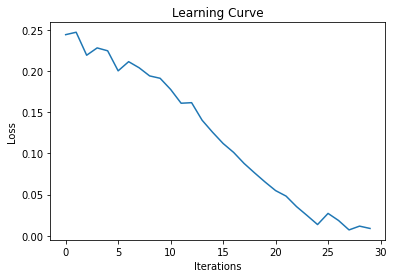

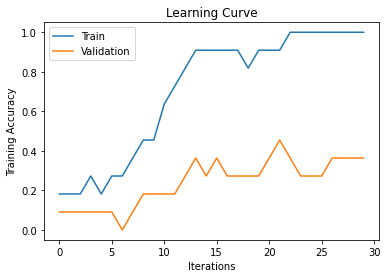

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.36363636363636365


In [ ]:
small_model = CNN()
train(small_model, small_train_data, small_valid_data, batch_size=9,
      num_epochs=30)

## Question 4. Training

### Part (a) -- 5 points

Train your first network on your training set.
Plot the training curve, and include your plot in your writeup.

Make sure that you are checkpointing frequently!

Epoch 1: Training Accuracy 0.24420190995907232, Validation Accuracy 0.32367149758454106
Epoch 2: Training Accuracy 0.3096862210095498, Validation Accuracy 0.34299516908212563
Epoch 3: Training Accuracy 0.45566166439290584, Validation Accuracy 0.45893719806763283
Epoch 4: Training Accuracy 0.5566166439290586, Validation Accuracy 0.5942028985507246
Epoch 5: Training Accuracy 0.6371077762619373, Validation Accuracy 0.6280193236714976
Epoch 6: Training Accuracy 0.7148703956343793, Validation Accuracy 0.6666666666666666
Epoch 7: Training Accuracy 0.8076398362892224, Validation Accuracy 0.7294685990338164


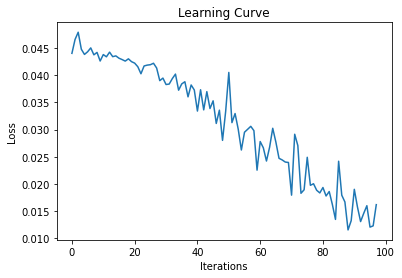

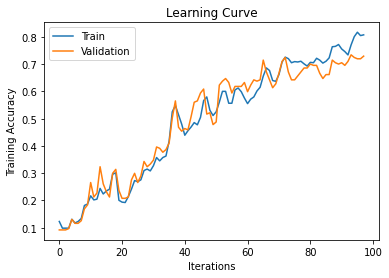

Final Training Accuracy: 0.8076398362892224
Final Validation Accuracy: 0.7294685990338164


In [ ]:
cnn_model = CNN()
train(cnn_model, train_data, valid_data, batch_size=50)

### Part (b) -- 2 points

You should have tried several hyperparameter choices before deciding on one set
of hyperparameters to use for Part (a).
In this section, briefly explain the hyperparamter choices that you tried,
and how they impacted your training.

In [ ]:
# Results of Changing batch_size/num_epochs:

# Keeping default batch_size:
  # Final Training Accuracy: 0.12141882673942701,
  # Final Validation Accuracy: 0.12077294685990338
# batch_size = 50:
  # Final Training Accuracy: 0.7517053206002728,
  # Final Validation Accuracy: 0.7294685990338164
# batch_size=75, num_epochs=6
  # Training Accuracy 0.3015006821282401,
  # Validation Accuracy 0.2898550724637681
# batch_size=60, num_epochs=8
  # Final Training Accuracy: 0.4106412005457026,
  # Final Validation Accuracy: 0.3719806763285024

# Batch Size

# Changing the batch size had significant effects on the validation accuracy of
# the model. For instance, increasing the batch size to 50 increased
# both the training and validation accuracy from about 12% to about %75.
# Therefore, batch size is a hyperparamter that can be tuned to
# achieve a higher validation accuracy in the CNN model.

# Results of changing learning rate:

# learning_rate=0.002, batch_size=50
  # Final Training Accuracy: 0.791268758526603,
  # Final Validation Accuracy: 0.7294685990338164
# learning_rate=0.0005, batch_size=50
  # Final Training Accuracy: 0.6002728512960437,
  # Final Validation Accuracy: 0.6183574879227053

# Learning rate

# Changing the learning rate alters the accuracy within the model,
# therefore the learning rate is also a hyperparamter that can be tuned to
# obtain higher training and validation accuracy. In our observations when
# training, changing the learning rate resulted in differences in the
# validation accuracies, specifically by about a 20% shift. When changing the
# learning rate from 0.002 to 0.0005, we saw a decrease in validation accuracy
# from about 73% to about 61%. As a result, tuning this hyperparameter showed
# to be beneficial for the model's performance.


### Part (c) -- 5 points

Train your second network on your training set.
Plot the training curve, and include your plot in your writeup.

Make sure that you are checkpointing frequently!

Epoch 1: Training Accuracy 0.165075034106412, Validation Accuracy 0.14009661835748793
Epoch 2: Training Accuracy 0.42155525238744884, Validation Accuracy 0.4396135265700483
Epoch 3: Training Accuracy 0.7967257844474761, Validation Accuracy 0.6376811594202898
Epoch 4: Training Accuracy 0.931787175989086, Validation Accuracy 0.6666666666666666
Epoch 5: Training Accuracy 0.9863574351978172, Validation Accuracy 0.748792270531401
Epoch 6: Training Accuracy 0.9890859481582538, Validation Accuracy 0.7681159420289855
Epoch 7: Training Accuracy 0.9931787175989086, Validation Accuracy 0.6956521739130435


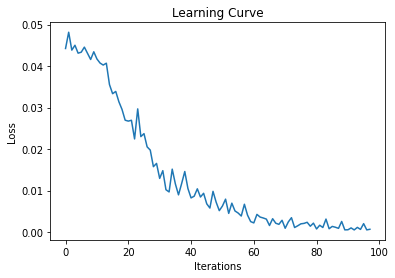

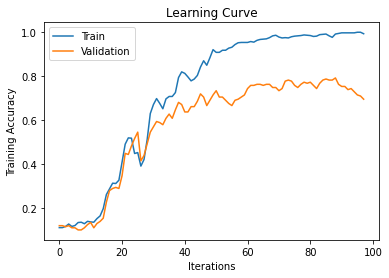

Final Training Accuracy: 0.9931787175989086
Final Validation Accuracy: 0.6956521739130435


In [ ]:
cnn_batch_model = CNNBatch()
train(cnn_batch_model, train_data, valid_data, batch_size=50)

### Part (d) -- 2 points

You should have tried several hyperparameter choices before deciding on one set
of hyperparameters to use for Part (c).
In this section, briefly explain the hyperparamter choices that you tried,
and how they impacted your training.

In [ ]:
# Results of changing Batch layers in model:
# two batch layers:
  # Training Accuracy = 0.9959072305593452,
  # Final Validation Accuracy = 0.7391304347826086
# one batch layer:
  # Final Training Accuracy: 0.9931787175989086,
  # Final Validation Accuracy: 0.7729468599033816

# Number of Batch layers

# Changing the number of batch layers causes the validation accuracy within
# the model to fluxuate, therefore the number of batch layers can be used as
# a hyperparamter that can be tuned to obtain a higher validation accuracy.
# In our results changing the number of batch layers from two to one increases
# the final validation accuracy from about 73% to 77%, so trying different
# number of batch layers can potentially help the model reach its optimal
# validation accuracy.


# Results of changing batch size, and learning rate
# batch_size=50, num_epochs=6
  # Training Accuracy 0.9645293315143247,
  # Validation Accuracy 0.7874396135265701
# num_epochs=6, learning_rate=0.002
  # Final Training Accuracy: 0.9004092769440655,
  # Final Validation Accuracy: 0.6956521739130435
# learning_rate=0.0005
  # Training Accuracy 0.9945429740791268,
  # Validation Accuracy 0.7971014492753623 (both kept increasing)
# batch_size=64, learning_rate=0.0005
  # Training Accuracy 0.9140518417462483,
  # Validation Accuracy 0.7536231884057971

# Batch size and Learning rate

# Changing the learning rate, alters the accuracy within the model,
# therefore the learning rate is a hyperparameter that can be tuned to obtain
# a higher validation accuracy. In our observations when training,
# changing the learning rate resulted in differences in the accuracies with
# the CNN Batch model, specfically about 20% shift in accuracies when doubling
# the learning rate from its default value . When changing the learning rate
# from 0.002 to 0.0005, we saw an increase in validation accuracy from about
# 69% to about 79%. Along with changing the learning rate, changing the batch
# size in the CNN batch model, we witnessed fluxuating in the model's
# validation accuracy. Using the learning rate of 0.0005 with batch size 64,
# led to a decrease in validation accuracy. Therefore, both the learning rate
# and batch size are hyperparameters than can be tuned to acheive a higher
# validation accuracy.


### Part (e) -- 1 pts

Out of all the models (i.e. parts (a) vs (c), and the various hyperparameter choices)
that you tried, which model is the "best"?
If you were to select a single set of weight values (checkpoints)
to deploy and use in a real application, which would you choose?

In [ ]:
# CNN, batch_size = 50:
  # Final Training Accuracy: 0.8076398362892224,
  # Final Validation Accuracy: 0.7294685990338164

# Out of all the models (i.e. parts (a) vs (c), and the various hyperparameter
# choices) that we tried, the above trained model is the "best". The training
# accuracy is not very close to 100%, so the model is not overfitting on the
# training data. Moreover, the traning and valiadation accuracies are
# relatively high and close to one another. This is a good sign as the model
# is not overfitting and will be a better representation of the real world,
# allowing the model to preform reasonable well on unseen data.

## Question 5. Transfer Learning

For many image classification tasks, it is generally not a good idea to train a
very large deep neural network model from scratch due to the enormous compute
requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a
similar task to the one you need to solve. This method of using a
pre-trained network for other similar tasks is broadly termed
**Transfer Learning**. In this question, we will use Transfer Learning
to extract features from the hand gesture images. Then, train a smaller
network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, the AlexNet architecture played a pivotal role in
establishing Deep Neural Nets as a go-to tool for image classification
problems and we will use an ImageNet pre-trained AlexNet model to
extract features in this assignment.

### Part (a)

Here is the code to load the AlexNet network, with pretrained weights.
When you first run the code, PyTorch will download the pretrained weights
from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The `alexnet` model is split up into two components: `alexnet.features` and
`alexnet.classifier`.  The first neural network component, `alexnet.features`,
is used to
computed convolutional features, which is taken as input in `alexnet.classifier`.

The neural network `alexnet.features` expects an image tensor of shape
Nx3x224x224 as inputs and it will output a tensor of shape Nx256x6x6 . (N = batch size).

Here is an example code snippet showing how you can compute the AlexNet
features for some images (your actual code might be different):

In [ ]:
img, label = train_data[0]
features = alexnet.features(img.unsqueeze(0)).detach()

Note that the `.detach()` at the end will be necessary in your code. The reason is that
PyTorch automatically builds computation graphs to be able to backpropagate
gradients. If we did not explicitly "detach" this tensor from the AlexNet portion
of the computation graph, PyTorch might try to backpropagate gradients to the AlexNet
weight and tune the AlexNet weights.

Compute the AlexNet features for each of your training, validation, and test data.
In other words, create three new arrays called `train_data_features`, `valid_data_features`
and `test_data_features`. Each of these arrays should contain tuples of the form
`(alexnet_features, label)`

In [ ]:

train_data_features = []
for img, y in train_data:
  features = alexnet.features(img.unsqueeze(0)).detach()
  train_data_features.append((features, y),)

valid_data_features = []
for img, y in valid_data:
  features = alexnet.features(img.unsqueeze(0)).detach()
  valid_data_features.append((features, y),)

test_data_features = []
for img, y in test_data:
  features = alexnet.features(img.unsqueeze(0)).detach()
  test_data_features.append((features, y),)

### Part (b)


Create a multi-layer preceptron that
takes **as input** these AlexNet features,
and makes a prediction. Your model should be a subclass of `nn.Module`.

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_hidden):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(256 * 6 * 6, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 9)
        self.num_hidden = num_hidden

    def forward(self, x):

        flattened = x.view(-1, 256 * 6 * 6)
        activation1 = self.layer1(flattened)
        activation1 = torch.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

### Part (c)

Train the `MLP()` model for at least 6 epochs, and report
on the maximum validation accuracy that you can attain.

This model should train *much* faster since it has very few parameters.
However, this model should attain much better accuracy much faster!

Epoch 1: Training Accuracy 0.7094133697135061, Validation Accuracy 0.7536231884057971
Epoch 2: Training Accuracy 0.8472032742155525, Validation Accuracy 0.8067632850241546
Epoch 3: Training Accuracy 0.8758526603001364, Validation Accuracy 0.8695652173913043
Epoch 4: Training Accuracy 0.8908594815825375, Validation Accuracy 0.8599033816425121
Epoch 5: Training Accuracy 0.8949522510231923, Validation Accuracy 0.8695652173913043
Epoch 6: Training Accuracy 0.8963165075034106, Validation Accuracy 0.8792270531400966
Epoch 7: Training Accuracy 0.9931787175989086, Validation Accuracy 0.8840579710144928


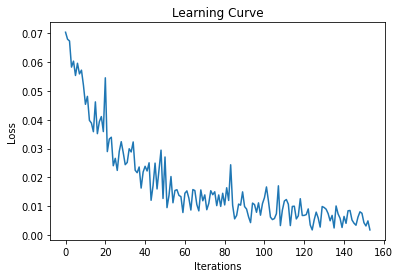

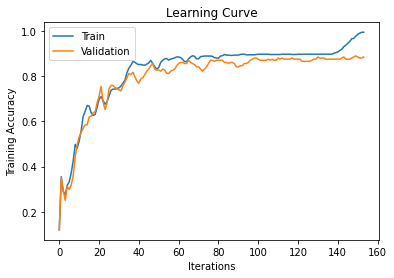

Final Training Accuracy: 0.9931787175989086
Final Validation Accuracy: 0.8840579710144928


In [ ]:
mlp = MLP(12)
train(mlp, train_data_features, valid_data_features)

## Question 6. Test Accuracy

### Part (a) -- 5 pts

Report the test accuracies of your **single best** model for the test set, including
any model that you trained (including in Q5).

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report
print(get_accuracy(cnn_model, test_data))
print(get_accuracy(cnn_batch_model, test_data))
print(get_accuracy(mlp, test_data_features))

0.6547085201793722
0.6457399103139013
0.7713004484304933


### Part (b) -- 1 pts

Display one image that your model correctly classified.

tensor([[0]])
0


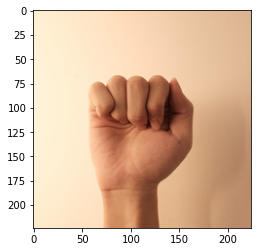

In [ ]:
# Make sure both your code and image are visible to the TA
img = plt.imread("/content/gdrive/My Drive/CSC413/asl_data/test/A/01_A_1.jpg")
plt.imshow(img)
output = mlp(test_data_features[0][0])
pred = output.max(1, keepdim=True)[1]
print(pred)
print(test_data_features[0][1])

### Part (b) -- 1 pts

Display one image that your model incorrectly classified. (If your test performance was 100%, please just say so.)

tensor([[6]])
0


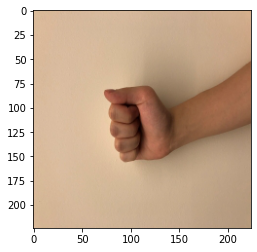

In [ ]:
img = plt.imread("/content/gdrive/My Drive/CSC413/asl_data/test/A/05_A_1.jpg")
plt.imshow(img)
output = mlp(test_data_features[12][0])
pred = output.max(1, keepdim=True)[1]
print(pred)
print(test_data_features[12][1])

## Question 6. Adversarial Examples -- 2 pts

In this question you will take the trained model you selected in Q4 (e),
and you will freeze its weights (i.e. do not optimize it further). Let's call this model $f()$.
Select an image (let's call it $x$) from the test set, where $f(x)$ outputs the correct label $y$.
Then, compute an adversarial noise image (let's call it $n$) that you will add to $x$ in order to change
the original label to an incorrect one, i.e. $f(x + n) \neq f(x)$, while keeping the value of the noise
pixels small, i.e. $|n_{i,j}| < \epsilon$. You have control over $\epsilon$, but keep in mind that the
noise should be imperceptible to the human eye when not zooming into the image.

tensor([[0]])
tensor([[8]])


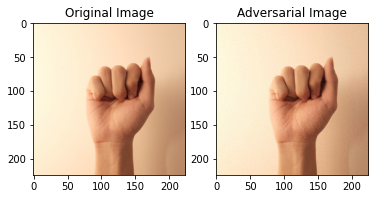

In [ ]:
#
# Make sure your code, original image x, and the corrupted image x + n are
# shown to the TA
# Show the output f(x) = y and the output f(x + n) is different than y.
#

for param in cnn_model.parameters():
  param.requires_grad = False

x, y = test_data[2]
x = x.unsqueeze(0)
y = torch.tensor([y])

x.requires_grad = True
output = cnn_model(x)
print(output.max(1, keepdim=True)[1])

loss = nn.CrossEntropyLoss()(output, y)
grad = torch.autograd.grad(loss, x)[0]
sign_grad = torch.sign(grad)
epsilon = 0.01
n = epsilon * sign_grad
x_adv = x + n
adv_output = cnn_model(x_adv)
print(adv_output.max(1, keepdim=True)[1])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x.detach().squeeze().permute(1, 2, 0))
axs[0].set_title("Original Image")
axs[1].imshow(x_adv.detach().squeeze().permute(1, 2, 0))
axs[1].set_title("Adversarial Image")
plt.show()

## Question 7. Work Allocation -- 1 pts

This question is to make sure that if you are working with a partner, that
you and your partner contributed equally to the assignment.

Please have each team member write down the times that you worked on the
assignment, and your contribution to the assignment.

In [ ]:
# Time: Equal Time spent on the Assignment (Working on it together,
# often same time)

# Muhammad Haris Idrees:
# Contribution: CNN Model, CNN Batch Model, Architecture Decision,
# Hyperparameters, Transfer Learning model and data.

# Samantha Skeels:
# Contribution: Data (Q1), Accuracy/Training Code & Overfitting to
# Small Dataset, Training on models, Test accuracy, Adversarial Example